# Summary of time taken and brier scores for jaxlogit, xlogit, and biogeme
Where the estimation is using draws = 600 (suboptimal but highest without running out of memory in biogeme), and training and test data is separated.

| | jaxlogit | xlogit | biogeme |
|---|---|---|---|
|Making Model | 37.7s | 16.9s | 4:15 |
|Estimating | 1.6s | 0.0s | 15.4s |
|Brier Score | 0.6345 | 0.6345 | 0.6345 |

# Setup

In [2]:
import pandas as pd
import numpy as np
import jax
import pathlib
import xlogit
import sklearn
from time import time
import sys
import io

from jaxlogit.mixed_logit import MixedLogit, ConfigData
from jaxlogit.utils import wide_to_long

import biogeme.biogeme_logging as blog
import biogeme.biogeme as bio
from biogeme import models
from biogeme.expressions import Beta, Draws, log, MonteCarlo, PanelLikelihoodTrajectory
import biogeme.database as db
from biogeme.expressions import Variable

logger = blog.get_screen_logger()
logger.setLevel(blog.INFO)

#  64bit precision
jax.config.update("jax_enable_x64", True)

# Get the full electricity dataset

Use for jaxlogit and xlogit. Adjustusting n_draws can improve accuracy, but Biogeme cannot handle 700 or more draws with this data set.

In [3]:
df = pd.read_csv(pathlib.Path.cwd() / "electricity_long.csv")
varnames = ['pf', 'cl', 'loc', 'wk', 'tod', 'seas']
n_draws = 600
quick_draws_biogeme = [100, 200, 300, 400, 500, 600]
quick_draws_extended = [700, 800, 900, 1000, 1500, 2000, 2500, 3000, 4000, 5000]

In [4]:
rdf_fit = pd.DataFrame(columns=["package", "draws", "time"])
rdf_predict = pd.DataFrame(columns=["package", "time"])

Reshape the data so it can be passed to test_train_split in a wide format. Additionally, xlogit and jaxlogit require long format while biogeme requires a wide format.

In [5]:
df_long = pd.read_csv(pathlib.Path.cwd() / "electricity_long.csv")
choice_df = df_long.loc[df_long['choice'] == 1, ['id', 'chid', 'alt']]
choice_df = choice_df.rename(columns={'alt': 'choice'})
df_wide = df_long.pivot(index=['id', 'chid'], columns='alt', values=varnames)
df_wide.columns = [f'{var}_{alt}' for var, alt in df_wide.columns]
df_wide = df_wide.reset_index()
df = df_wide.merge(
    choice_df,
    on=['id', 'chid'],
    how='inner',
    validate='one_to_one'
)

df_wide_train, df_wide_test = sklearn.model_selection.train_test_split(df, train_size=0.8)
df_train = wide_to_long(df_wide_train, "chid", [1,2,3,4], "alt", varying=varnames, panels=True)
df_train = df_train.sort_values(['chid', 'alt'])
df_test = wide_to_long(df_wide_test, "chid", [1,2,3,4], "alt", varying=varnames, panels=True)
df_test = df_test.sort_values(['chid', 'alt'])

database_train = db.Database('electricity', df_wide_train)
database_train.panel('id')
database_test = db.Database('electricity', df_wide_test)

jaxlogit and xlogit setup:

In [6]:
X_train = df_train[varnames]
y_train = df_train['choice']

ids_train = df_train['chid']
alts_train = df_train['alt']
panels_train = df_train['id']

X_test = df_test[varnames]
y_test = df_test['choice']

ids_test = df_test['chid']
alts_test = df_test['alt']
panels_test = df_test['id']

In [7]:
randvars = {'pf': 'n', 'cl': 'n', 'loc': 'n', 'wk': 'n', 'tod': 'n', 'seas': 'n'}

model_jax = MixedLogit()
model_x = xlogit.MixedLogit()

init_coeff = None

Biogeme setup:

In [8]:
X = {
    name: {
        j: Variable(f"{name}_{j}")
        for j in [1,2,3,4]
    }
    for name in varnames
}

alt_1 = Beta('alt_1', 0, None, None, 0)
alt_2 = Beta('alt_2', 0, None, None, 0)
alt_3 = Beta('alt_3', 0, None, None, 0)
alt_4 = Beta('alt_4', 0, None, None, 1)

pf_mean = Beta('pf_mean', 0, None, None, 0)
pf_sd = Beta('pf_sd', 1, None, None, 0)
cl_mean = Beta('cl_mean', 0, None, None, 0)
cl_sd = Beta('cl_sd', 1, None, None, 0)
loc_mean = Beta('loc_mean', 0, None, None, 0)
loc_sd = Beta('loc_sd', 1, None, None, 0)
wk_mean = Beta('wk_mean', 0, None, None, 0)
wk_sd = Beta('wk_sd', 1, None, None, 0)
tod_mean = Beta('tod_mean', 0, None, None, 0)
tod_sd = Beta('tod_sd', 1, None, None, 0)
seas_mean = Beta('seas_mean', 0, None, None, 0)
seas_sd = Beta('seas_sd', 1, None, None, 0)

pf_rnd = pf_mean + pf_sd * Draws('pf_rnd', 'NORMAL')
cl_rnd = cl_mean + cl_sd * Draws('cl_rnd', 'NORMAL')
loc_rnd = loc_mean + loc_sd * Draws('loc_rnd', 'NORMAL')
wk_rnd = wk_mean + wk_sd * Draws('wk_rnd', 'NORMAL')
tod_rnd = tod_mean + tod_sd * Draws('tod_rnd', 'NORMAL')
seas_rnd = seas_mean + seas_sd * Draws('seas_rnd', 'NORMAL')

choice = Variable('choice')

V = {
    j: pf_rnd * X['pf'][j] + cl_rnd * X['cl'][j] + loc_rnd * X['loc'][j] + wk_rnd * X['wk'][j] + tod_rnd * X['tod'][j] + seas_rnd * X['seas'][j]
    for j in [1,2,3,4]
}

# Make the models
Jaxlogit:

In [9]:
for draw in (quick_draws_biogeme + quick_draws_extended):
    print(draw)
    start_time = time()
    config = ConfigData(
        panels=panels_train,
        n_draws=draw,
        skip_std_errs=True,  # skip standard errors to speed up the example
        batch_size=None,
        optim_method="L-BFGS-B",
    )
    init_coeff = None
    
    model_jax.fit(
        X=X_train,
        y=y_train,
        varnames=varnames,
        ids=ids_train,
        alts=alts_train,
        randvars=randvars,
        config=config
    )
    ellapsed = time() - start_time
    rdf_fit.loc[len(rdf_fit)] = ['jaxlogit', draw, ellapsed]
display(model_jax.summary())
init_coeff_j = model_jax.coeff_

100
200
300
400
500
600
700
800
900
1000
1500
2000
2500
3000
4000
5000
    Message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
    Iterations: 49
    Function evaluations: 60
Estimation time= 166.4 seconds
---------------------------------------------------------------------------
Coefficient              Estimate      Std.Err.         z-val         P>|z|
---------------------------------------------------------------------------
pf                     -1.0224256     1.0000000    -1.0224256         0.307    
cl                     -0.2499177     1.0000000    -0.2499177         0.803    
loc                     2.3255438     1.0000000     2.3255438        0.0201 *  
wk                      1.6244924     1.0000000     1.6244924         0.104    
tod                    -9.7998870     1.0000000    -9.7998870       2.2e-22 ***
seas                  -10.0349221     1.0000000   -10.0349221      2.23e-23 ***
sd.pf                  -1.3922816     1.0000000    -1.3922816         0.164 

None

xlogit:

In [36]:
for draw in (quick_draws_biogeme + quick_draws_extended):
    start_time = time()
    model_x.fit(
        X=X_train,
        y=y_train,
        varnames=varnames,
        ids=ids_train,
        alts=alts_train,
        randvars=randvars,
        panels=panels_train,
        n_draws=draw,
        skip_std_errs=True,  # skip standard errors to speed up the example
        batch_size=None,
        optim_method="L-BFGS-B",
    )
    ellapsed = time() - start_time
    rdf_fit.loc[len(rdf_fit)] = ['xlogit', draw, ellapsed]
display(model_x.summary())
init_coeff_x = model_x.coeff_

Optimization terminated successfully.
    Message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
    Iterations: 74
    Function evaluations: 86
Estimation time= 163.9 seconds
---------------------------------------------------------------------------
Coefficient              Estimate      Std.Err.         z-val         P>|z|
---------------------------------------------------------------------------
pf                     -1.0163158     1.0000000    -1.0163158          0.31    
cl                     -0.2479289     1.0000000    -0.2479289         0.804    
loc                     2.3141051     1.0000000     2.3141051        0.0207 *  
wk                      1.6142002     1.0000000     1.6142002         0.107    
tod                    -9.7902048     1.0000000    -9.7902048      2.42e-22 ***
seas                  -10.0013885     1.0000000   -10.0013885      3.11e-23 ***
sd.pf                  -0.2192235     1.0000000    -0.2192235         0.826    
sd.cl                   0.418

None

Biogeme:

In [11]:
for draw in quick_draws_biogeme:
    print(f"starting draw {draw}")
    start_time = time()
    prob = models.logit(V, None, choice)
    logprob = log(MonteCarlo(PanelLikelihoodTrajectory(prob)))

    the_biogeme = bio.BIOGEME(
        database_train, logprob, number_of_draws=draw, seed=999, generate_yaml=False, generate_html=False
    )
    the_biogeme.model_name = 'model_b'
    results = the_biogeme.estimate()
    print(results)
    ellapsed = time() - start_time
    rdf_fit.loc[len(rdf_fit)] = ['biogeme', draw, ellapsed]

starting draw 100


The number of draws (100) is low. The results may not be meaningful. 
The number of draws (100) is low. The results may not be meaningful. 


Results for model model_b
Nbr of parameters:		12
Sample size:			361
Observations:			3446
Excluded data:			0
Final log likelihood:		-3235.633
Akaike Information Criterion:	6495.267
Bayesian Information Criterion:	6541.933

starting draw 200


The number of draws (200) is low. The results may not be meaningful. 
The number of draws (200) is low. The results may not be meaningful. 


Results for model model_b
Nbr of parameters:		12
Sample size:			361
Observations:			3446
Excluded data:			0
Final log likelihood:		-3220.94
Akaike Information Criterion:	6465.88
Bayesian Information Criterion:	6512.547

starting draw 300


The number of draws (300) is low. The results may not be meaningful. 
The number of draws (300) is low. The results may not be meaningful. 


Results for model model_b
Nbr of parameters:		12
Sample size:			361
Observations:			3446
Excluded data:			0
Final log likelihood:		-3199.949
Akaike Information Criterion:	6423.898
Bayesian Information Criterion:	6470.565

starting draw 400


The number of draws (400) is low. The results may not be meaningful. 
The number of draws (400) is low. The results may not be meaningful. 


Results for model model_b
Nbr of parameters:		12
Sample size:			361
Observations:			3446
Excluded data:			0
Final log likelihood:		-3199.141
Akaike Information Criterion:	6422.283
Bayesian Information Criterion:	6468.949

starting draw 500


The number of draws (500) is low. The results may not be meaningful. 
The number of draws (500) is low. The results may not be meaningful. 


Results for model model_b
Nbr of parameters:		12
Sample size:			361
Observations:			3446
Excluded data:			0
Final log likelihood:		-3189.269
Akaike Information Criterion:	6402.539
Bayesian Information Criterion:	6449.205

starting draw 600


The number of draws (600) is low. The results may not be meaningful. 
The number of draws (600) is low. The results may not be meaningful. 


Results for model model_b
Nbr of parameters:		12
Sample size:			361
Observations:			3446
Excluded data:			0
Final log likelihood:		-3179.264
Akaike Information Criterion:	6382.527
Bayesian Information Criterion:	6429.194



# Compare parameters:

In [12]:
print("{:>13} {:>13} {:>13} {:>13}".format("Estimate", "Jaxlogit", "xlogit", "Biogeme"))
print("-" * 58)
fmt = "{:13} {:13.7f} {:13.7f} {:13.7f}"
coeff_names = {'pf': 'pf_mean', 'sd.pf': 'pf_sd', 'cl': 'cl_mean', 'sd.cl': 'cl_sd', 'loc': 'loc_mean', 'sd.loc': 'loc_sd', 'wk': 'wk_mean', 'sd.wk': 'wk_sd', 'tod': 'tod_mean', 'sd.tod': 'tod_sd', 'seas': 'seas_mean', 'sd.seas': 'seas_sd'}
for i in range(len(model_jax.coeff_)):
    name = model_jax.coeff_names[i]
    print(fmt.format(name[:13], 
                     model_jax.coeff_[i], 
                     model_x.coeff_[i], 
                     results.get_beta_values()[coeff_names[name]]))
print("-" * 58)

     Estimate      Jaxlogit        xlogit       Biogeme
----------------------------------------------------------
pf               -1.0224256    -1.0163158    -1.0085904
cl               -0.2499177    -0.2479289    -0.2422836
loc               2.3255438     2.3141051     2.2142136
wk                1.6244924     1.6142002     1.6037306
tod              -9.7998870    -9.7902048    -9.6382369
seas            -10.0349221   -10.0013885    -9.9494076
sd.pf            -1.3922816    -0.2192235    -0.2312255
sd.cl            -0.6480669     0.4180928     0.4184881
sd.loc            1.6891869     1.8278596     1.7500696
sd.wk             0.7139723     1.0948196     1.0655358
sd.tod            2.4348390     2.5186781     2.4730163
sd.seas           1.5137454     1.7594053    -1.5954838
----------------------------------------------------------


# Predict
jaxlogit:

In [13]:
model = model_jax 
config = ConfigData(
    panels=panels_test,
    n_draws=n_draws,
    skip_std_errs=True,  # skip standard errors to speed up the example
    batch_size=None,
    optim_method="L-BFGS-B",
)
config.init_coeff = init_coeff_j
start_time = time()
prob_jj = model.predict(X_test, varnames, alts_test, ids_test, randvars, config)
ellapsed = time() - start_time
rdf_predict.loc[len(rdf_predict)] = ['jaxlogit', ellapsed]

xlogit:

In [ ]:
start_time = time()
_, prob_xx = model_x.predict(X_test, varnames, alts_test, ids_test, isvars=None, panels=panels_test, n_draws=n_draws, return_proba=True)
ellapsed = time() - start_time
rdf_predict.loc[len(rdf_predict)] = ['xlogit', ellapsed]

Biogeme:

In [15]:
start_time = time()
P = {
    j: MonteCarlo(models.logit(V, None, j))
    for j in [1, 2, 3, 4]
}

simulate = {
    f'Prob_alt{j}': P[j]
    for j in [1, 2, 3, 4]
}

biogeme_sim = bio.BIOGEME(database_test, simulate)
biogeme_sim.model_name = 'per_choice_probs'

probs = biogeme_sim.simulate(results.get_beta_values())
ellapsed = time() - start_time
rdf_predict.loc[len(rdf_predict)] = ['biogeme', ellapsed]

Compute the brier score:

In [16]:
print("{:>9} {:>9} {:>9}".format("Jaxlogit", "xlogit", "Biogeme"))
print("-" * 31)
fmt = "{:9f} {:9f} {:9f}"
print(fmt.format(sklearn.metrics.brier_score_loss(np.reshape(y_test, (prob_jj.shape[0], -1)), prob_jj),
                 sklearn.metrics.brier_score_loss(np.reshape(y_test, (prob_xx.shape[0], -1)), prob_xx),
                 sklearn.metrics.brier_score_loss(df_wide_test['choice'], probs)))
print("-" * 31)

 Jaxlogit    xlogit   Biogeme
-------------------------------
 0.632292  0.632609  0.632002
-------------------------------


In [ ]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 14,
                            'axes.spines.right': False,
                            'axes.spines.top': False})
markers = {'jaxlogit': '.', 'xlogit': 'x', 'biogeme': 'v'}
colors = {'jaxlogit': '#e41a1c', 'xlogit': '#ff7f00', 'biogeme': '#984ea3'}
libs = ['jaxlogit', 'xlogit', 'biogeme']

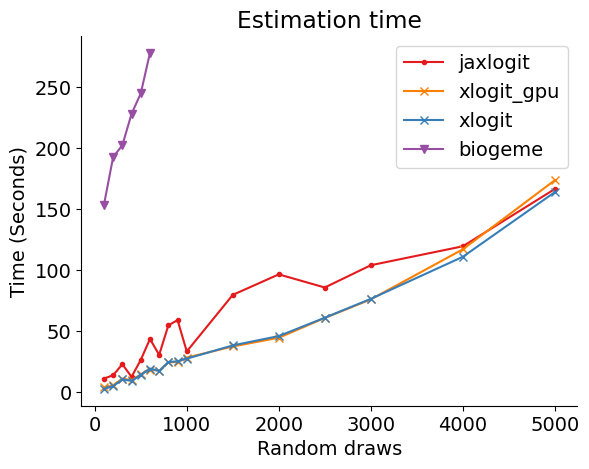

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (4,) and arg 1 with shape (3,).

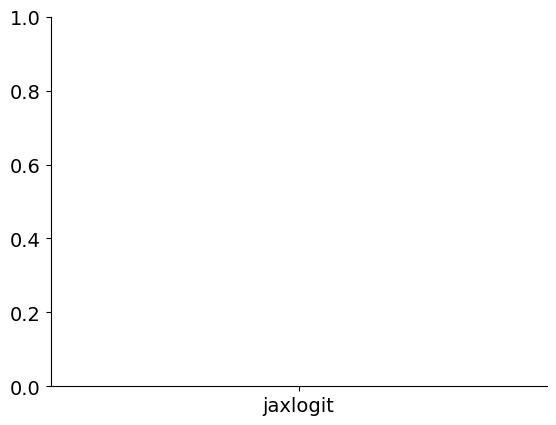

In [41]:
def plot(df, name):
    for lib in libs:
        rdf = df.loc[df["package"] == lib]
        plt.plot(rdf["draws"], rdf["time"], label=lib, marker=markers[lib], c=colors[lib])
    plt.legend()
    plt.xlabel("Random draws")
    plt.ylabel("Time (Seconds)")
    plt.title("Estimation time")
    plt.savefig(name)
    plt.show()
    plt.close()

plot(rdf_fit, "fit_estimation_time")

def bar(df, name):
    plt.bar(libs, df["time"], color=colors.values())
    plt.xlabel("Package")
    plt.ylabel("Time (Seconds)")
    plt.title("Predict time")
    plt.savefig(name)

bar(rdf_predict, "predict_time")

In [ ]:
import json

# Dump all of rdf_fit
# list = rdf_fit.values.tolist()
# with open("comparison_data_fit.json", "w") as f:
#     json.dump(list, f)

# Retrieve all of rdf_fit
with open("comparison_data_fit.json", "r") as f:
    fit_data = json.load(f)
rdf_fit = pd.DataFrame(fit_data)
rdf_fit.columns = ["package", "draws", "time"]


rdf_fit["package"] = rdf_fit["package"].replace('xlogit_gpu', 'xlogit')
print(rdf_fit)

       package  draws        time
0     jaxlogit    100   11.308059
1     jaxlogit    200   13.993378
2     jaxlogit    300   23.044688
3     jaxlogit    400   12.687592
4     jaxlogit    500   26.545866
5     jaxlogit    600   43.696281
6     jaxlogit    700   30.709175
7     jaxlogit    800   54.838855
8     jaxlogit    900   59.124948
9     jaxlogit   1000   33.471206
10    jaxlogit   1500   79.773704
11    jaxlogit   2000   96.551530
12    jaxlogit   2500   85.807161
13    jaxlogit   3000  104.036162
14    jaxlogit   4000  119.539232
15    jaxlogit   5000  166.431362
16  xlogit_gpu    100    4.011977
17  xlogit_gpu    200    5.717992
18  xlogit_gpu    300   11.307617
19  xlogit_gpu    400    9.868472
20  xlogit_gpu    500   14.754068
21  xlogit_gpu    600   18.710267
22  xlogit_gpu    700   17.654293
23  xlogit_gpu    800   24.512272
24  xlogit_gpu    900   24.892062
25  xlogit_gpu   1000   28.463397
26  xlogit_gpu   1500   37.552093
27  xlogit_gpu   2000   44.717556
28  xlogit_gpu